<a href="https://colab.research.google.com/github/Flukasiew/ColabExperiments/blob/master/DatasetGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Znalazlem dwie interesujace Biblioteki dotyczace generowanie muzyki w roznych formatach.

In [2]:
!pip install mingus 
!pip install python-ly

In [42]:
import mingus.extra.lilypond as LilyPond
from mingus.containers.bar import Bar
b = Bar()
b + "C"
b + "E"
b + "G"
b + "B"
bar = LilyPond.from_Bar(b)
LilyPond.to_png(bar, "Users\my_first_bar") # it can here create png 

Executing: lilypond -fpng -o "Users\my_first_bar" "Users\my_first_bar.ly"


True

Problem to brak programu  w colabie lilypond ale spokojnie jest do zrobienia.

mingus pozwala na generowanie z takiego ciagu zarowno midi jak i png.

python-ly pozwala generowac music-xml z LilyPond stringow

Wiec jesli zdecydujemy sie na zakres dzwiekow ktory chcemy miec w zbiorze moge zabrac sie za pisanie jakiegos generatora a potem "filtrow" na te png 

PRÓBAAAA

In [43]:
# Zabawy Janusza

## Generator LilyPondów

In [44]:
import mingus.core.notes as notes
from mingus.containers import Note, NoteContainer, Bar, Track, Instrument
import random
import mingus.extra.lilypond as LilyPond

In [45]:
#stałe globalne

allNotesM = ["A-3", "B-3", "C-4", "D-4","E-4", "F-4", "G-4", "A-4", "B-4", "C-5", "D-5", "E-5", "F-5", "G-5", "A-5", "B-5", "C-6" ]
lenAllNotesM = len(allNotesM)
largestInterval = 4
pOfChromatics=.05

quarterGroupOptions16 = [[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[.5,.5],[.5,.5],[.5,.5],[.5,.5],[.5,.5],[.5,.5], [.5, .5], [.25, .25, .5], [.5, .25, .25], [.25, .25, .25, .25]]
quarterGroupOptions8 = [[1],[1],[1],[0.5,0.5]]
bar4GroupOptions = [[4], [2,2], [2,1,1],[2,1,1],[1,1,2],[1,1,2],[1,1,1,1],[1,1,1,1]]
bar3GroupOptions = [[2,1],[1,2],[1,1,1]]

pOfRests=.1

### Generowanie melodii

In [46]:
# jeśli before=-1 -> pierwsza nuta
def newNoteIndexM(before):
    if before==-1:
        return random.randint(0,lenAllNotesM-1)
    
    if before<largestInterval:
        return random.randint(0,2*largestInterval)
    
    if before>lenAllNotesM-largestInterval-1:
        return random.randint(lenAllNotesM-2*largestInterval, lenAllNotesM-1)
        
    return random.randint(before-largestInterval,before+largestInterval-1)

In [47]:
# dla length>0
def newNoteIndexListM(length):
    prev = newNoteIndexM(-1)
    melody = [prev]
    for i in range(1,length):
        prev = newNoteIndexM(prev)
        melody.append(prev)
    return melody

In [48]:
def newMelodyWithoutChromatics(length):
    return [Note(allNotesM[a]) for a in newNoteIndexListM(length)]

In [49]:
newMelodyWithoutChromatics(10)

['C-5', 'D-5', 'C-5', 'F-5', 'E-5', 'G-5', 'C-5', 'D-5', 'F-5', 'A-5']

In [50]:
def newMelody(length):
    melody = []   
    for index in newNoteIndexListM(length):
        k = random.random()
        note = Note(allNotesM[index])
        if k<pOfChromatics:
            note.augment()
        elif k>1-pOfChromatics:
            note.diminish()
        melody.append(note)
    return melody

In [51]:
newMelody(10)

['C-5', 'D-5', 'C-5', 'A-4', 'D-5', 'G-4', 'F-4', 'B-4', 'C-5', 'E-5']

### Generowanie rytmu

In [52]:
def newQuarterGroup(with16):
    if with16:
        return random.choice(quarterGroupOptions16)
    else:
        return random.choice(quarterGroupOptions8)

In [53]:
newQuarterGroup(True)

[1]

In [54]:
def newBarRhythm(beats,with16):
    finalRhythm=[]
    if beats==4:
        rhythm = random.choice(bar4GroupOptions)
    if beats==3:
        rhythm = random.choice(bar3GroupOptions)
    
    for ii in range(len(rhythm)):
        if rhythm[ii]==1:
            finalRhythm.extend(newQuarterGroup(with16))
        else:
            finalRhythm.append(rhythm[ii])
    return finalRhythm

In [55]:
print('4/4 Bar: ', newBarRhythm(4,True))
print('3/4 Bar: ', newBarRhythm(3,False))

4/4 Bar:  [2, 1, 1]
3/4 Bar:  [2, 0.5, 0.5]


### Generowanie ścieżki

In [56]:
# NewTrack(liczba_uderzeń_w_takcie, liczba_taktów, czy_z_chromatyką, czy_z_16)
def NewTrack(beats,count,withChromatics,with16):
    track=Track(Instrument())
    rhythms=[]
    noOfNotes=0
    melodyCount=0
    
    for ii in range(count):
        rhythms.append(newBarRhythm(beats,with16))
        noOfNotes+=len(rhythms[ii])
    
    if withChromatics:
        melody = newMelody(noOfNotes)
    else:
        melody = newMelodyWithoutChromatics(noOfNotes)
    
    for rhythm in rhythms:
        b = Bar('C',(beats,4))
        for note in rhythm:
            k=random.random()
            if k>pOfRests:
                b.place_notes(melody[melodyCount], 4/note)
            else:
                b.place_notes(None, 4/note)
            melodyCount+=1
        track+b
    return track

In [57]:
NewTrack(4,10,True,True)

[Instrument ['C-0' - 'C-8'], [[[0.0, 2.0, ['D-5']], [0.5, 2.0, ['C-5']]], [[0.0, 8.0, ['E-5']], [0.125, 8.0, ['C-5']], [0.25, 4.0, ['F-4']], [0.5, 2.0, ['A-4']]], [[0.0, 2.0, ['F-4']], [0.5, 4.0, ['Gb-4']], [0.75, 4.0, ['B-4']]], [[0.0, 4.0, ['F-4']], [0.25, 4.0, ['B-3']], [0.5, 4.0, ['A-3']], [0.75, 8.0, ['B-3']], [0.875, 8.0, ['A-3']]], [[0.0, 4.0, ['A-3']], [0.25, 16.0, ['B-3']], [0.3125, 16.0, ['D-4']], [0.375, 16.0, ['Fb-4']], [0.4375, 16.0, ['F-4']], [0.5, 8.0, ['A-4']], [0.625, 8.0, ['F-4']], [0.75, 4.0, ['A-4']]], [[0.0, 2.0, None], [0.5, 2.0, ['A-4']]], [[0.0, 8.0, ['C-5']], [0.125, 8.0, ['Bb-4']], [0.25, 4.0, ['E-5']], [0.5, 2.0, None]], [[0.0, 4.0, ['E-4']], [0.25, 4.0, ['G-4']], [0.5, 8.0, ['F-4']], [0.625, 8.0, ['C-4']], [0.75, 8.0, ['A-3']], [0.875, 8.0, ['D-4']]], [[0.0, 8.0, ['G-4']], [0.125, 8.0, ['A-4']], [0.25, 4.0, ['D-4']], [0.5, 2.0, ['G-4']]], [[0.0, 8.0, None], [0.125, 8.0, ['E-4']], [0.25, 4.0, ['B-3']], [0.5, 8.0, ['A-4']], [0.625, 16.0, ['G-4']], [0.6875, 16.

### Generowanie notacji w formacie LilyPond

In [58]:
track = NewTrack(4,6,False,False)
lp = LilyPond.from_Track(track)
print(lp)

{ { a2 e'2 } { a4 c'4 b4 c'8 f'8 } { b'2 d''4 f''4 } { b'2 a'4 r4 } { r1 } { d'2 b2 } }


## No clef or time in the picture

In [59]:
delete_clef_string = " \n \override Staff.Clef.color = #white \n \override Staff.Clef.layer = #-1"
delete_time_string = " \n \override Staff.TimeSignature.color = #white \n \override Staff.TimeSignature.layer = #-1"

def CleanTrack(track):
    track = track[0] + delete_clef_string + delete_time_string+ track[1:]
    return track

## Generate Cropped png

In [60]:
import subprocess
import os

def GenerateCropped(ly_string, filename, command='-fpng'):
    """Generates cropped PNG it is slightly changed version of minugs save_string_and_execute_LilyPond function"""
    ly_string = '\\version "2.10.33"\n' + ly_string
    if filename[-4] in ['.pdf' or '.png']:
        filename = filename[:-4]
    try:
        f = open(filename + '.ly', 'w')
        f.write(ly_string)
        f.close()
    except:
        return False
    command = 'lilypond -dpreview %s -o "%s" "%s.ly"' % (command, filename, filename)
    print('Executing: %s' % command)
    p = subprocess.Popen(command, shell=True).wait()
    os.remove(filename + '.ly')
    return True

In [61]:
track = NewTrack(4,6,False,False)
lp = LilyPond.from_Track(track)
print(lp)
c_track = CleanTrack(lp)

{ { a2 g'4 f'8 b'8 } { e'8 c'8 c'4 r4 r4 } { c'2 c'8 a'8 c''8 f'8 } { a'8 b'8 c''4 b'8 c''8 g'8 g'8 } { e'2 a'2 } { d''2 d''2 } }


In [62]:
GenerateCropped(c_track,"my_first_track")

Executing: lilypond -dpreview -fpng -o "my_first_track" "my_first_track.ly"


True

## Convert to jpg

In [63]:
from PIL import Image

def imgConvert(from_name, to_name):
    im = Image.open(from_name)
    rgb_im = im.convert('RGB')
    rgb_im.save(to_name)

In [64]:
imgConvert("my_first_track.preview.png", "track.jpg")

## Transformations

In [65]:
from functools import reduce
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
# Construct 3D rotation matrix when rotations around x,y,z axes are specified 
def construct_RotationMatrixHomogenous(rotation_angles):
    assert(type(rotation_angles)==list and len(rotation_angles)==3)
    RH = np.eye(4,4)
    cv2.Rodrigues(np.array(rotation_angles), RH[0:3, 0:3])
    return RH

In [67]:
# https://en.wikipedia.org/wiki/Rotation_matrix
def getRotationMatrixManual(rotation_angles):
    
    rotation_angles = [ np.deg2rad(x) for x in rotation_angles]
    
    phi         = rotation_angles[0] # around x
    gamma       = rotation_angles[1] # around y
    theta       = rotation_angles[2] # around z
    
    # X rotation
    Rphi        = np.eye(4,4)
    sp          = np.sin(phi)
    cp          = np.cos(phi)
    Rphi[1,1]   = cp
    Rphi[2,2]   = Rphi[1,1]
    Rphi[1,2]   = -sp
    Rphi[2,1]   = sp
    
    # Y rotation
    Rgamma        = np.eye(4,4)
    sg            = np.sin(gamma)
    cg            = np.cos(gamma)
    Rgamma[0,0]   = cg
    Rgamma[2,2]   = Rgamma[0,0]
    Rgamma[0,2]   = sg
    Rgamma[2,0]   = -sg
    
    # Z rotation (in-image-plane)
    Rtheta      = np.eye(4,4)
    st          = np.sin(theta)
    ct          = np.cos(theta)
    Rtheta[0,0] = ct
    Rtheta[1,1] = Rtheta[0,0]
    Rtheta[0,1] = -st
    Rtheta[1,0] = st
    
    R           = reduce(lambda x,y : np.matmul(x,y), [Rphi, Rgamma, Rtheta]) 
    
    return R

In [68]:
def getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sidelength):
    
    ptsIn2D      =  ptsIn[0,:]
    ptsOut2D     =  ptsOut[0,:]
    ptsOut2Dlist =  []
    ptsIn2Dlist  =  []
    
    for i in range(0,4):
        ptsOut2Dlist.append([ptsOut2D[i,0], ptsOut2D[i,1]])
        ptsIn2Dlist.append([ptsIn2D[i,0], ptsIn2D[i,1]])
    
    pin  =  np.array(ptsIn2Dlist)   +  [W/2.,H/2.]
    pout = (np.array(ptsOut2Dlist)  +  [1.,1.]) * (0.5*sidelength)
    pin  = pin.astype(np.float32)
    pout = pout.astype(np.float32)
    
    return pin, pout

In [69]:
def warpMatrix(W, H, theta, phi, gamma, scale, fV):
    
    # M is to be estimated
    M          = np.eye(4, 4)
    
    fVhalf     = np.deg2rad(fV/2.)
    d          = np.sqrt(W*W+H*H)
    sideLength = scale*d/np.cos(fVhalf)
    h          = d/(2.0*np.sin(fVhalf))
    n          = h-(d/2.0);
    f          = h+(d/2.0);
    
    # Translation along Z-axis by -h
    T       = np.eye(4,4)
    T[2,3]  = -h
    
    # Rotation matrices around x,y,z
    R = getRotationMatrixManual([phi, gamma, theta])
    
    
    # Projection Matrix 
    P       = np.eye(4,4)
    P[0,0]  = 1.0/np.tan(fVhalf)
    P[1,1]  = P[0,0]
    P[2,2]  = -(f+n)/(f-n)
    P[2,3]  = -(2.0*f*n)/(f-n)
    P[3,2]  = -1.0
    
    # pythonic matrix multiplication
    F       = reduce(lambda x,y : np.matmul(x,y), [P, T, R]) 
    
    # shape should be 1,4,3 for ptsIn and ptsOut since perspectiveTransform() expects data in this way. 
    # In C++, this can be achieved by Mat ptsIn(1,4,CV_64FC3);
#    ptsIn = np.array([[
#                 [-W/2., H/2., 0.],[ W/2., H/2., 0.],[ W/2.,-H/2., 0.],[-W/2.,-H/2., 0.]
#                 ]])
    ptsIn = np.array([[
                 [-W/2., -H/2., 0.],[ W/2., -H/2., 0.],[ -W/2.,H/2., 0.],[W/2.,H/2., 0.]
                 ]])
    ptsOut  = np.array(np.zeros((ptsIn.shape), dtype=ptsIn.dtype))
    ptsOut  = cv2.perspectiveTransform(ptsIn, F)
    
    ptsInPt2f, ptsOutPt2f = getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sideLength)
    # check float32 otherwise OpenCV throws an error
    assert(ptsInPt2f.dtype  == np.float32)
    assert(ptsOutPt2f.dtype == np.float32)
    M33 = cv2.getPerspectiveTransform(ptsInPt2f,ptsOutPt2f)

    return M33, sideLength, ptsInPt2f, ptsOutPt2f

In [70]:
def warpImage(src,theta, phi,gamma,scale,fovy,corners=None):
    H,W,Nc    = src.shape
    M,sl,ptsIn, ptsOut      = warpMatrix(W,H, theta,phi,gamma, scale,fovy);          #Compute warp matrix
    sl = int(sl)
    #print('Output image dimension = {}'.format(sl))
    dst = cv2.warpPerspective(src,M, (sl,sl),borderValue=[255,255,255]); #Do actual image warp
    left_right_margin = random.uniform(2,50)
    top_bot_margin = random.uniform(2,50)
    left_upper = [min([x[0] for x in ptsOut]),min([x[1] for x in ptsOut])]
    right_lower = [max([x[0] for x in ptsOut]),max([x[1] for x in ptsOut])]
    left_upper[0] = int(max(left_upper[0]-left_right_margin,0))
    left_upper[1] = int(max(left_upper[1]-top_bot_margin,0))
    right_lower[0] = int(min(right_lower[0]+left_right_margin,sl-1))
    right_lower[1] = int(min(right_lower[1]+top_bot_margin,sl-1))
    return dst[left_upper[1]:right_lower[1],left_upper[0]:right_lower[0]]

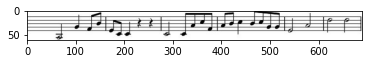

In [71]:
src   = cv2.imread('track.jpg')
src    = src[...,::-1] # BGR to RGB
H,W,Nc = src.shape
plt.imshow(src)

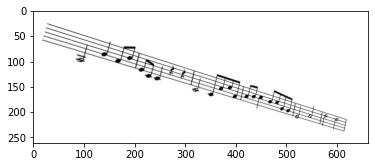

In [72]:
imgwarped = warpImage(src, 15, 0, 30, 1.,45)
plt.imshow(imgwarped)
from PIL import Image
im = Image.fromarray(imgwarped)
im.save("waped_track.jpg")

In [73]:
def randomWarpImage(src,x_range=15,y_range=15,z_range=15):
    x_angle = int(random.uniform(-x_range,x_range))
    y_angle = int(random.uniform(-y_range,y_range))
    z_angle = int(random.uniform(-z_range,z_range))
    fov = int(random.uniform(30,50))
    warped_image = warpImage(src,x_angle,y_angle,z_angle,1,fov)
    return warped_image

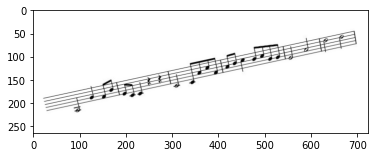

In [74]:
imgwarped = randomWarpImage(src)
plt.imshow(imgwarped)
from PIL import Image
im = Image.fromarray(imgwarped)
im.save("waped_track.jpg")

In [1]:
x_range = 10
y_range = 10
z_range = 10
beats = random.choices([3,4],weights=[0.25,0.75], k=1)[0]
count = int(random.uniform(1,5))

NameError: name 'random' is not defined

Executing: lilypond -dpreview -fpng -o "tmp_track" "tmp_track.ly"
{ { e''4 a''4 e''4 a''8 f''8 } { d''2 c''4 e''4 } { d''2 a'4 a'8 a'8 } { g'8 c''8 a'4 d'2 } { f'2 g'8 b'8 r4 } { g'1 } { e'4 a'4 b'2 } { c''4 e''4 f''4 b'8 f'8 } { g'2 d'2 } }


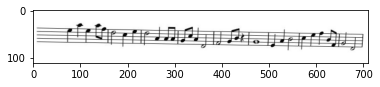

In [85]:
track = NewTrack(beats,count,withChromatics=False,with16=False)
track_string = LilyPond.from_Track(track)
track_string_clean = CleanTrack(track_string)
GenerateCropped(track_string_clean,"tmp_track")
imgConvert("tmp_track.preview.png", "tmp_track.jpg")
src   = cv2.imread('tmp_track.jpg')
src    = src[...,::-1] # BGR to RGB
im = randomWarpImage(src,x_range,y_range,z_range)
print(track_string)
plt.imshow(im)